[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/time-travel.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239536-lesson-5-time-travel)

# 시간 여행(Time travel)

## 복습

우리는 Human-in-the-Loop의 동기에 대해 논의했습니다:

(1) `승인` - 에이전트를 중단하고, 사용자에게 상태를 표시하며, 사용자가 작업을 승인할 수 있도록 할 수 있습니다

(2) `디버깅` - 그래프를 되감아 문제를 재현하거나 회피할 수 있습니다

(3) `편집` - 상태를 수정할 수 있습니다

중단점이 특정 노드에서 그래프를 중지하거나 그래프가 동적으로 스스로 중단하도록 할 수 있는 방법을 보여주었습니다.

그런 다음 사람의 승인을 받아 진행하거나 사람의 피드백으로 그래프 상태를 직접 편집하는 방법을 보여주었습니다.

## 목표

이제 LangGraph가 과거 상태를 보고, 재생하고, 심지어 분기하여 [디버깅을 지원](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/time-travel/)하는 방법을 보여드리겠습니다.

우리는 이것을 `시간 여행(time travel)`이라고 부릅니다.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

In [2]:
from dotenv import load_dotenv

load_dotenv("../.env", override=True)

True

In [3]:
import os
import getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

에이전트를 구축해봅시다.

In [4]:
from langchain_openai import ChatOpenAI


def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b


tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

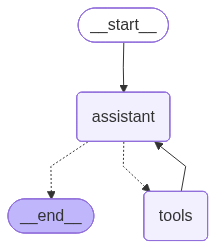

In [7]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(
    content="당신은 입력 세트에 대한 산술 연산을 수행하는 유용한 어시스턴트입니다."
)


# Node
def assistant(state: MessagesState):
    response = llm_with_tools.invoke([sys_msg] + state["messages"])
    return {"messages": [response]}


# Graph
builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

이전처럼 실행해봅시다.

In [8]:
initial_input = {"messages": HumanMessage(content="2와 3을 곱하세요")}

thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

2와 3을 곱하세요
================================== Ai Message ==================================
Tool Calls:
  multiply (call_4aJg1UguZJz6ExpPoKfIWbyQ)
 Call ID: call_4aJg1UguZJz6ExpPoKfIWbyQ
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

2와 3을 곱한 결과는 6입니다.


## 히스토리 탐색

`thread_id`가 주어지면 `get_state`를 사용하여 그래프의 **현재** 상태를 볼 수 있습니다!

In [9]:
graph.get_state({"configurable": {"thread_id": "1"}})

StateSnapshot(values={'messages': [HumanMessage(content='2와 3을 곱하세요', additional_kwargs={}, response_metadata={}, id='973bbdd9-135a-440e-a1bb-8267d382b673'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4aJg1UguZJz6ExpPoKfIWbyQ', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 143, 'total_tokens': 160, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CLjVBdNwV81YrVxtykppccxbINyGk', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d7964d00-abd9-43f7-90d4-a3af0ca81911-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_4aJg1UguZJz6E

에이전트의 상태 히스토리도 탐색할 수 있습니다.

`get_state_history`를 사용하면 이전의 모든 단계에서의 상태를 가져올 수 있습니다.

In [10]:
all_states = [s for s in graph.get_state_history(thread)]

In [11]:
len(all_states)

5

In [12]:
all_states

[StateSnapshot(values={'messages': [HumanMessage(content='2와 3을 곱하세요', additional_kwargs={}, response_metadata={}, id='973bbdd9-135a-440e-a1bb-8267d382b673'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4aJg1UguZJz6ExpPoKfIWbyQ', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 143, 'total_tokens': 160, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CLjVBdNwV81YrVxtykppccxbINyGk', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d7964d00-abd9-43f7-90d4-a3af0ca81911-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_4aJg1UguZJz6

첫 번째 요소는 `get_state`에서 얻은 것과 동일한 현재 상태입니다.

In [13]:
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='2와 3을 곱하세요', additional_kwargs={}, response_metadata={}, id='973bbdd9-135a-440e-a1bb-8267d382b673')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f09e85e-2fdd-6880-8000-8aba4d5c508d'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-01T05:17:12.461111+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f09e85e-2fdc-6624-bfff-2641c9a2f85d'}}, tasks=(PregelTask(id='d2f0d45b-ebb0-3c18-1eeb-0e7dc5411ad8', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4aJg1UguZJz6ExpPoKfIWbyQ', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 143, 'total

위의 모든 것을 여기서 시각화할 수 있습니다:

![fig1.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038211b544898570be3_time-travel1.png)

## Replaying 

이전 단계 중 어느 곳에서든 에이전트를 다시 실행할 수 있습니다.

![fig2.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038a0bd34b541c78fb8_time-travel2.png)

사람의 입력을 받은 단계를 다시 살펴봅시다!

In [14]:
to_replay = all_states[-2]

In [15]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='2와 3을 곱하세요', additional_kwargs={}, response_metadata={}, id='973bbdd9-135a-440e-a1bb-8267d382b673')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f09e85e-2fdd-6880-8000-8aba4d5c508d'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-01T05:17:12.461111+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f09e85e-2fdc-6624-bfff-2641c9a2f85d'}}, tasks=(PregelTask(id='d2f0d45b-ebb0-3c18-1eeb-0e7dc5411ad8', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4aJg1UguZJz6ExpPoKfIWbyQ', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 143, 'total

상태를 확인해봅시다.

In [10]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', id='4ee8c440-0e4a-47d7-852f-06e2a6c4f84d')]}

다음에 호출할 노드를 확인할 수 있습니다.

In [11]:
to_replay.next

('assistant',)

또한 `checkpoint_id`와 `thread_id`를 알려주는 config도 얻을 수 있습니다.

In [12]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef6a440-a003-6c74-8000-8a2d82b0d126'}}

여기서부터 재생하려면 `config`를 에이전트에 다시 전달하기만 하면 됩니다!

그래프는 이 체크포인트가 이미 실행되었다는 것을 알고 있습니다.

이 체크포인트부터 재생합니다!

In [16]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

2와 3을 곱하세요
================================== Ai Message ==================================
Tool Calls:
  multiply (call_QVuxfFne1fVNTBHhCTOKHQ6a)
 Call ID: call_QVuxfFne1fVNTBHhCTOKHQ6a
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

2와 3을 곱한 결과는 6입니다.


이제 에이전트가 다시 실행된 후의 현재 상태를 볼 수 있습니다.

## 분기(Forking)

같은 단계에서 실행하되 다른 입력으로 실행하고 싶다면 어떻게 할까요?

이것이 분기입니다.

![fig3.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038f89f2d847ee5c336_time-travel3.png)

In [17]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='2와 3을 곱하세요', additional_kwargs={}, response_metadata={}, id='973bbdd9-135a-440e-a1bb-8267d382b673')]

다시, config가 있습니다.

In [18]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09e85e-2fdd-6880-8000-8aba4d5c508d'}}

이 체크포인트에서 상태를 수정해봅시다.

`checkpoint_id`를 제공하여 `update_state`를 실행하면 됩니다.

`messages`의 리듀서가 어떻게 작동하는지 기억하세요:

* 메시지 ID를 제공하지 않으면 추가합니다.
* 상태에 추가하는 대신 메시지를 덮어쓰려면 메시지 ID를 제공합니다!

따라서 메시지를 덮어쓰려면 `to_fork.values["messages"].id`에 있는 메시지 ID를 제공하기만 하면 됩니다.

In [19]:
fork_config = graph.update_state(
    to_fork.config,
    {
        "messages": [
            HumanMessage(
                content="5와 3을 곱하세요.",
                id=to_fork.values["messages"][0].id,
            )
        ]
    },
)

In [20]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09e869-d3aa-603e-8001-f4d1a9e01058'}}

이것은 새로운 분기된 체크포인트를 생성합니다.
 
하지만 메타데이터는 보존됩니다!

에이전트의 현재 상태가 우리의 분기로 업데이트된 것을 볼 수 있습니다.

In [21]:
all_states = [state for state in graph.get_state_history(thread)]
all_states[0].values["messages"]

[HumanMessage(content='5와 3을 곱하세요.', additional_kwargs={}, response_metadata={}, id='973bbdd9-135a-440e-a1bb-8267d382b673')]

In [22]:
graph.get_state({"configurable": {"thread_id": "1"}})

StateSnapshot(values={'messages': [HumanMessage(content='5와 3을 곱하세요.', additional_kwargs={}, response_metadata={}, id='973bbdd9-135a-440e-a1bb-8267d382b673')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f09e869-d3aa-603e-8001-f4d1a9e01058'}}, metadata={'source': 'update', 'step': 1, 'parents': {}}, created_at='2025-10-01T05:22:24.915661+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f09e85e-2fdd-6880-8000-8aba4d5c508d'}}, tasks=(PregelTask(id='d6f509e5-cdd8-5fbd-2395-2f37c1badd6c', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

이제 스트림할 때, 그래프는 이 체크포인트가 실행된 적이 없다는 것을 알고 있습니다.

따라서 그래프는 단순히 재생하는 대신 실행됩니다.

In [23]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

5와 3을 곱하세요.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_crtTt2gk1VgLRuqjtwaO5dMz)
 Call ID: call_crtTt2gk1VgLRuqjtwaO5dMz
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

5와 3을 곱하면 15입니다.


이제 현재 상태가 에이전트 실행의 끝임을 볼 수 있습니다.

In [24]:
graph.get_state({"configurable": {"thread_id": "1"}})

StateSnapshot(values={'messages': [HumanMessage(content='5와 3을 곱하세요.', additional_kwargs={}, response_metadata={}, id='973bbdd9-135a-440e-a1bb-8267d382b673'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_crtTt2gk1VgLRuqjtwaO5dMz', 'function': {'arguments': '{"a":5,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 144, 'total_tokens': 161, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CLjb6pRmEJCHOCBn2ylYcCXUXRhcE', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1413bd57-6634-4cac-9f90-b209718317ec-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 3}, 'id': 'call_crtTt2gk1VgL

### LangGraph API를 사용한 시간 여행

로컬 개발 서버를 시작하려면 이 모듈의 `/studio` 디렉토리에서 터미널에 다음 명령어를 실행하세요:

```sh
langgraph dev
```

다음과 같은 출력을 볼 수 있습니다:
```sh
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

브라우저를 열고 Studio UI로 이동하세요: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

SDK를 통해 연결하고 LangGraph API가 [시간 여행을 지원](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_time_travel/#initial-invocation)하는 방법을 보여드립니다.

In [ ]:
from langgraph_sdk import get_client

client = get_client(url="http://127.0.0.1:2024")

#### Re-playing 

각 노드가 호출된 후 그래프 상태에 대한 `updates`를 스트리밍하여 에이전트를 실행해봅시다.

In [ ]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()

async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get("assistant", {}).get("messages", [])
        tool_node = chunk.data.get("tools", {}).get("messages", [])
        if assisant_node:
            print("-" * 20 + "Assistant Node" + "-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20 + "Tools Node" + "-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_SG7XYqDENGq7mwXrnioNLosS', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-2c120fc3-3c82-4599-b8ec-24fbee207cad', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_SG7XYqDENGq7mwXrnioNLosS', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': None}
--------------------Tools Node--------------------
{'content': '6', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '3b40d091-58b2-4566-a84c-60af67206307', 'tool_call_id': 'call_SG7XYqDENGq7mwXrnioNLosS', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': 

이제 지정된 체크포인트부터 **replaying**하는 것을 살펴봅시다.

`checkpoint_id`를 전달하기만 하면 됩니다.

In [ ]:
states = await client.threads.get_history(thread["thread_id"])
to_replay = states[-2]
to_replay

{'values': {'messages': [{'content': 'Multiply 2 and 3',
    'additional_kwargs': {'example': False,
     'additional_kwargs': {},
     'response_metadata': {}},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': 'df98147a-cb3d-4f1a-b7f7-1545c4b6f042',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': 'e497456f-827a-5027-87bd-b0ccd54aa89a',
   'name': 'assistant',
   'error': None,
   'interrupts': [],
   'state': None}],
 'metadata': {'step': 0,
  'run_id': '1ef6a449-7fbc-6c90-8754-4e6b1b582790',
  'source': 'loop',
  'writes': None,
  'parents': {},
  'user_id': '',
  'graph_id': 'agent',
  'thread_id': '708e1d8f-f7c8-4093-9bb4-999c4237cb4a',
  'created_by': 'system',
  'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca'},
 'created_at': '2024-09-03T22:33:51.380352+00:00',
 'checkpoint_id': '1ef6a449-817f-6b55-8000-07c18fbdf7c8',
 'parent_checkpoint_id': '1ef6a449-816c-6fd6-bfff-32a56dd2635f'}

재생할 때 모든 노드에서 전체 상태를 보기 위해 `stream_mode="values"`로 스트리밍해봅시다.

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    checkpoint_id=to_replay["checkpoint_id"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '1ef6a44a-5806-6bb1-b2ee-92ecfda7f67d'}



Receiving new event of type: values...
{'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'df98147a-cb3d-4f1a-b7f7-1545c4b6f042', 'example': False}]}



Receiving new event of type: values...
{'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'df98147a-cb3d-4f1a-b7f7-1545c4b6f042', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_Rn9YQ6iZyYtzrELBz7EfQcs0', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_1

우리가 재생하는 노드들에 의해 만들어진 상태에 대한 `updates`만 스트리밍하는 것으로도 모두 볼 수 있습니다.

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=to_replay["checkpoint_id"],
):
    if chunk.data:
        assisant_node = chunk.data.get("assistant", {}).get("messages", [])
        tool_node = chunk.data.get("tools", {}).get("messages", [])
        if assisant_node:
            print("-" * 20 + "Assistant Node" + "-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20 + "Tools Node" + "-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_I2qudhMCwcw1GzcFN5q80rjj', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-550e75ad-dbbc-4e55-9f00-aa896228914c', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_I2qudhMCwcw1GzcFN5q80rjj', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': None}
--------------------Tools Node--------------------
{'content': '6', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '731b7d4f-780d-4a8b-aec9-0d8b9c58c40a', 'tool_call_id': 'call_I2qudhMCwcw1GzcFN5q80rjj', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': 

#### 분기(Forking)

이제 분기를 살펴봅시다.

위에서 다뤘던 것과 동일한 단계인 사람의 입력을 가져옵시다.

에이전트와 함께 새 스레드를 생성해봅시다.

In [ ]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()

async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get("assistant", {}).get("messages", [])
        tool_node = chunk.data.get("tools", {}).get("messages", [])
        if assisant_node:
            print("-" * 20 + "Assistant Node" + "-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20 + "Tools Node" + "-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_HdWoyLELFZGEcqGxFt2fZzek', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-cbd081b1-8cef-4ca8-9dd5-aceb134404dc', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_HdWoyLELFZGEcqGxFt2fZzek', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': None}
--------------------Tools Node--------------------
{'content': '6', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '11dd4a7f-0b6b-44da-b9a4-65f1677c8813', 'tool_call_id': 'call_HdWoyLELFZGEcqGxFt2fZzek', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': 

In [ ]:
states = await client.threads.get_history(thread["thread_id"])
to_fork = states[-2]
to_fork["values"]

{'messages': [{'content': 'Multiply 2 and 3',
   'additional_kwargs': {'example': False,
    'additional_kwargs': {},
    'response_metadata': {}},
   'response_metadata': {},
   'type': 'human',
   'name': None,
   'id': '93c18b95-9050-4a52-99b8-9374e98ee5db',
   'example': False}]}

In [ ]:
to_fork["values"]["messages"][0]["id"]

'93c18b95-9050-4a52-99b8-9374e98ee5db'

In [ ]:
to_fork["next"]

['assistant']

In [ ]:
to_fork["checkpoint_id"]

'1ef6a44b-27ec-681c-8000-ff7e345aee7e'

상태를 편집해봅시다.

`messages`의 리듀서가 어떻게 작동하는지 기억하세요:

* 메시지 ID를 제공하지 않으면 추가합니다.
* 상태에 추가하는 대신 메시지를 덮어쓰려면 메시지 ID를 제공합니다!

In [ ]:
forked_input = {
    "messages": HumanMessage(
        content="Multiply 3 and 3", id=to_fork["values"]["messages"][0]["id"]
    )
}

forked_config = await client.threads.update_state(
    thread["thread_id"], forked_input, checkpoint_id=to_fork["checkpoint_id"]
)

In [33]:
forked_config

{'configurable': {'thread_id': 'c99502e7-b0d7-473e-8295-1ad60e2b7ed2',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef6a44b-90dc-68c8-8001-0c36898e0f34'},
 'checkpoint_id': '1ef6a44b-90dc-68c8-8001-0c36898e0f34'}

In [ ]:
states = await client.threads.get_history(thread["thread_id"])
states[0]

{'values': {'messages': [{'content': 'Multiply 3 and 3',
    'additional_kwargs': {'additional_kwargs': {},
     'response_metadata': {},
     'example': False},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '93c18b95-9050-4a52-99b8-9374e98ee5db',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': 'da5d6548-62ca-5e69-ba70-f6179b2743bd',
   'name': 'assistant',
   'error': None,
   'interrupts': [],
   'state': None}],
 'metadata': {'step': 1,
  'source': 'update',
  'writes': {'__start__': {'messages': {'id': '93c18b95-9050-4a52-99b8-9374e98ee5db',
     'name': None,
     'type': 'human',
     'content': 'Multiply 3 and 3',
     'example': False,
     'additional_kwargs': {},
     'response_metadata': {}}}},
  'parents': {},
  'graph_id': 'agent'},
 'created_at': '2024-09-03T22:34:46.678333+00:00',
 'checkpoint_id': '1ef6a44b-90dc-68c8-8001-0c36898e0f34',
 'parent_checkpoint_id': '1ef6a44b-27ec-681c-8000-ff7e345aee7e'}

다시 실행하려면 `checkpoint_id`를 전달합니다.

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=forked_config["checkpoint_id"],
):
    if chunk.data:
        assisant_node = chunk.data.get("assistant", {}).get("messages", [])
        tool_node = chunk.data.get("tools", {}).get("messages", [])
        if assisant_node:
            print("-" * 20 + "Assistant Node" + "-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20 + "Tools Node" + "-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_aodhCt5fWv33qVbO7Nsub9Q3', 'function': {'arguments': '{"a":3,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-e9759422-e537-4b9b-b583-36c688e13b4b', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 3, 'b': 3}, 'id': 'call_aodhCt5fWv33qVbO7Nsub9Q3', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': None}
--------------------Tools Node--------------------
{'content': '9', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '89787b0b-93de-4c0a-bea8-d2c3845534e1', 'tool_call_id': 'call_aodhCt5fWv33qVbO7Nsub9Q3', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': 

### LangGraph Studio

`module-1/studio/langgraph.json`에 설정된 `module-1/studio/agent.py`를 사용하는 `agent`로 Studio UI에서 분기를 살펴봅시다.